This notebook implements pressure-rate deconvolution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expi
from math import log10
import scipy as sp
import scipy.signal as sg
from scipy import linalg
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def fill_center_up(matrix_d,index,center):
  for i in index:
    k_up=int(center-i)
    if i%2==0:
      matrix_d[k_up,center]=i*L1+i*L3
    else:
      matrix_d[k_up,center]=(i+1)*L1+(i-1)*L3
  return matrix_d

def fill_center_down(matrix_d,index,center):
  for i in index:
    k_down=int(center+i)
    if i%2==0:
      matrix_d[k_down,center]=i*L1+i*L3
    else:
      matrix_d[k_down,center]=(i-1)*L1+(i+1)*L3
  return matrix_d 

def fill_center_right(matrix_d,index,center):
  for i in index:
    k_right=int(center+i)
    if i%2==0:
      matrix_d[center,k_right]=i*L4+i*L2
    else:
      matrix_d[center,k_right]=(i+1)*L4+(i-1)*L2
  return matrix_d    

def fill_center_left(matrix_d,index,center):
  for i in index:
    k_left=int(center-i)
    if i%2==0:
      matrix_d[center,k_left]=i*L4+i*L2 
    else:
      matrix_d[center,k_left]=(i-1)*L4+(i+1)*L2
  return matrix_d 

def fill_northeast(matrix_d,index,center):
  for i in index:
    for j in index:
      i=int(i)
      j=int(j)
      matrix_d[i-1,int(center+j)]=np.sqrt(matrix_d[i-1,int(center)]**2+matrix_d[int(center),int(center+j)]**2)
  return matrix_d   

def fill_southeast(matrix_d,index,center):
  for i in index:
    for j in index:
      i=int(i)
      j=int(j)
      matrix_d[int(center+i),int(center+j)]=np.sqrt(matrix_d[int(center+i),int(center)]**2+matrix_d[int(center),int(center+j)]**2)
  return matrix_d  

def fill_northwest(matrix_d,index,center):
  for i in index:
    for j in index:
      i=int(i)
      j=int(j)
      matrix_d[i-1,j-1]=np.sqrt(matrix_d[i-1,int(center)]**2+matrix_d[int(center),j-1]**2)
  return matrix_d    

def fill_southwest(matrix_d,index,center):
  for i in index:
    for j in index:
      i=int(i)
      j=int(j)
      matrix_d[int(center+i),j-1]=np.sqrt(matrix_d[int(center+i),int(center)]**2+matrix_d[int(center),j-1]**2)
  return matrix_d   

def setup_matrix_d(n_grids,rw,L1,L2,L3,L4):

  matrix_d=np.zeros((n_grids,n_grids))
  center=int((n_grids-1)/2)
  index=np.linspace(1,center,center)
  matrix_d[center,center]=rw

  matrix_d=fill_center_up(matrix_d,index,center)
  matrix_d=fill_center_down(matrix_d,index,center)
  matrix_d=fill_center_right(matrix_d,index,center)
  matrix_d=fill_center_left(matrix_d,index,center)
  matrix_d=fill_northeast(matrix_d,index,center)
  matrix_d=fill_northwest(matrix_d,index,center)
  matrix_d=fill_southwest(matrix_d,index,center)
  matrix_d=fill_southeast(matrix_d,index,center)
  #cmap = plt.cm.RdYlBu 
  #plt.imshow(matrix_d,cmap=cmap)
  #plt.colorbar()
  return matrix_d

def calc_dp(k,por,h,ct,Bo,visc,q  ,skin,t,matrix_d,n_grids,center):
  kp=(19.03*q*Bo*visc/(k*h))
  matrix_p=np.zeros((n_grids,n_grids))

  for i in range(n_grids):
    for j in range(n_grids):
      matrix_p[i,j]=0.5*kp*-expi(-(0.25*por*visc*ct*matrix_d[i,j]**2)/(0.0003484*k*t))
  matrix_p[center,center]=kp*(-0.5*expi(-(0.25*por*visc*ct*matrix_d[center,center]**2)/(0.0003484*k*t))+skin)
  return np.sum(matrix_p)

def create_t(start,end,samples_per_decade):
  ndecades = log10(end) - log10(start)
  npoints = int(ndecades) * samples_per_decade
  points = np.logspace(log10(start), log10(end), num=npoints, endpoint=True, base=10)
  return points

def create_dpu(t_dec,k,por,h,ct,Bo,visc,q,skin,matrix_d,n_grids,center):
  dp=[]

  for t in t_dec:
    dp.append(calc_dp(k,por,h,ct,Bo,visc,q,skin,t,matrix_d,n_grids,center))
  dp=np.array(dp)
  return dp

def calc_derivative(time, pressure, factor_L):
    # inicializacao do fator_L e variaveis secundarias
    
    n_points = len(time)
    deriv_pressure = []
    deriv_time = []
    i = 0
    while i < n_points:
        t1 = time[i]
        p1 = pressure[i]
        # encontrar o ti-1
        j = i
        while j > 0:
            if time[j] < t1 / np.exp(factor_L):
                break
            j -= 1
        # encontrar o ti+1
        k = i
        while k < n_points-1:
            if time[k] > t1 * np.exp(factor_L):
                break
            k += 1

        p0, p2 = pressure[j], pressure[k]
        t0, t2 = time[j], time[k]
        log_t0 = np.log(t0) if t0 != 0 else 0
        log_t1 = np.log(t1) if t1 != 0 else 0
        log_t2 = np.log(t2) if t2 != 0 else 0
        w1 = log_t1 - log_t0
        w2 = log_t2 - log_t1
        m1 = (p1-p0)/w1 if w1 > 0 else 0
        m2 = (p2-p1)/w2 if w2 > 0 else 0
        tdpdt = m1*w2/(w1+w2) + m2*w1/(w1+w2)
        # calculo da derivada
        deriv_pressure.append(tdpdt)
        i+=1
        # retorna ambos os arrays (t e dpdt) como arrays numpy
    return np.array(deriv_pressure)

def unit_response(start,end,samples_per_decade,k,por,h,ct,Bo,visc,q,skin,matrix_d,n_grids,center):
  t_dec=create_t(start,end,samples_per_decade)
  dp_u=create_dpu(t_dec,k,por,h,ct,Bo,visc,q,skin,matrix_d,n_grids,center)
  der_u=calc_derivative(t_dec,dp_u,0.0)
  dp_u=dp_u/q
  der_u=der_u/q
  return t_dec,dp_u,der_u 

def kernel_conv(k,por,h,ct,Bo,visc,q,skin,t,matrix_d,n_grids,center):
  dp_u=create_dpu(t,k,por,h,ct,Bo,visc,q,skin,matrix_d,n_grids,center) 
  kernel=dp_u/q
  return kernel 

def toeplitz_matrix(qk): 
  padding = np.zeros(qk.shape[0] - 1, qk.dtype)
  first_col = qk
  first_row = np.r_[qk[0], padding]
  qkH = sp.linalg.toeplitz(first_col, first_row)
  return  qkH 

def curvature (der_u,t_u):
  final=len(der_u)-1
  i=1
  curv=[]
  while i<final:
    print(((np.log(der_u[i+1])+np.log(der_u[i-1])-2*np.log(der_u[i]))/(np.log(t_u[i]/t_u[i-1])))**2)
    curv.append(((np.log(der_u[i+1])+np.log(der_u[i-1])-2*np.log(der_u[i]))/(np.log(t_u[i]/t_u[i-1])))**2)
    i=i+1
  curv=np.sum(np.array(curv))
  return curv

def cvt(der_u,t_dec):
  a=np.c_[np.log(t_dec),der_u]
  dx_dt = np.gradient(a[:, 0])
  dy_dt = np.gradient(a[:, 1])
  ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)
  d2s_dt2 = np.gradient(ds_dt)
  d2x_dt2 = np.gradient(dx_dt)
  d2y_dt2 = np.gradient(dy_dt)
  curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5  
  return np.sum(curvature)

def dpu(dp_u0,der_u,t_u):
  dp_u=[]
  init_sum=dp_u0
  i=1
  while i<len(t_u):
    sum=init_sum+0.5*(der_u[i]+der_u[i-1])*np.log(t_u[i]/t_u[i-1])
    init_sum=sum
    dp_u.append(sum)
    i=i+1
  dp_u=np.array(dp_u)
  dp_u=np.append(dp_u0,dp_u)
  return dp_u  

def objective(x0,t_dec,tk,qk,pk,pi,f_curv):
  index=np.where(qk!=0.0)[0]
  p_int=dpu(0.01,x0,t_dec)
  curv=cvt(x0,t_dec)
  kernel=np.interp(tk,t_dec,p_int)
  kernel=toeplitz_matrix(kernel)
  dpwf = np.dot(kernel,np.diff(np.r_[0.0,qk]))
  pwf=pi-dpwf
  error=f_curv*curv**2+(pwf-pk)**2
  error[index]=0.0
  return error  

def vol_whittle(B,ct,der):
  V_inv=(1/24)*(1/ct)*B*(1/der[-1])
  return V_inv

def fix_der(der_u):
  der_u[0]=der_u[1]
  der_u[-1]=der_u[-2]
  return der_u
  

In [ ]:
k=50.0
por=0.2
h=25.0
ct=0.00020833
Bo=1.7497
visc=0.272591
#pi=537.4 #s175
pi=572.7 #s186
#pi=552.723 #s189

#pi=552.85 #s189


skin=3.8
rw=0.108

# even (L2,L4) horizontal, odd (L1,L3) vertical
L1=244.0
L2=700.0
L3=592.8
L4=2000.0
#---------------------------------------------------
n_grids=41
center=int((n_grids-1)/2) 
q_ref=15.9
#---------------------------------------------------
# numerical set-ups
matrix_d=setup_matrix_d(n_grids,rw,L1,L2,L3,L4)

In [ ]:
#s175=85.0
#s189=136.0
#s186=150.0
t_dec,dp_u,der_u=unit_response(0.001,150.0,5,k,por,h,ct,Bo,visc,q_ref,skin,matrix_d,n_grids,center)

In [ ]:
# lê dados
fid = 'drive/My Drive/Colab Notebooks/S.xlsx'
df = pd.read_excel(fid,sheet_name='s186')
tk = df['Time (day)'].values
tk[0]=0.001
qk = df['QO'].values
pk = df['Well Bottom-hole Pressure (kg/cm²)'].values
dpk = pi - pk
dtk = np.gradient(tk)
t_final=tk[-1]

In [ ]:
from scipy.optimize import least_squares
#first, no curvature
f_curv=1000.0
der_u=fix_der(der_u)

#first use the initial guess
res = least_squares(objective, args=(t_dec,tk,qk,pk,pi,f_curv), x0=der_u,bounds=(1e-3,1.0),jac='3-point',method='trf',verbose=2)

#then iterate on this one, must uncomment first!
#res = least_squares(objective, args=(t_dec,tk,qk,pk,pi,f_curv), x0=der_opt,bounds=(1e-3,1.0),jac='3-point',method='trf',verbose=2)

der_opt=res.x
dpu_opt=dpu(0.01,der_opt,t_dec)
kernel=np.interp(tk,t_dec,dpu_opt)
kernel=toeplitz_matrix(kernel)
dpwf = np.dot(kernel,np.diff(np.r_[0.0,qk]))
pwf=pi-dpwf

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4495e+04                                    1.29e+06    
       1              5         2.4410e+04      8.51e+01       4.79e-04       3.67e+06    
       2              6         2.4120e+04      2.90e+02       1.25e-04       2.08e+06    
       3              7         2.3910e+04      2.10e+02       1.24e-04       3.59e+06    
       4              8         2.3735e+04      1.75e+02       1.25e-04       2.04e+06    
       5              9         2.3357e+04      3.77e+02       1.24e-04       2.00e+06    
       6             10         2.3266e+04      9.12e+01       2.48e-04       3.49e+06    
       7             11         2.2991e+04      2.75e+02       6.23e-05       3.45e+06    
       8             12         2.2740e+04      2.51e+02       1.25e-04       4.01e+06    
       9             14         2.2624e+04      1.16e+02       3.08e-05       1.92e+06    

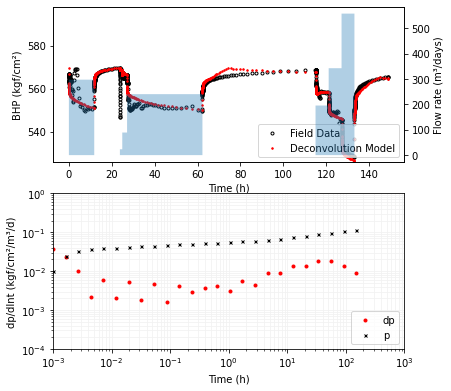

In [ ]:
#-------------------------------------------------------------------------------
# Plot pressure
#-------------------------------------------------------------------------------
fig, axes = plt.subplots(2,1,figsize=(6.3, 6.3))
axes[0].plot(tk, pk, 'ok', ms=3, markerfacecolor='None', label='Field Data')
axes[0].plot(tk, pwf, 'ro', ms=1.5, label='Deconvolution Model')
axes[0].grid(0)
axes[0].set_ylim([0.995*pk.min(),1.05*pk.max()])
axes[0].set_ylabel('BHP (kgf/cm²)')
axes[0].set_xlabel('Time (h)')
axes[0].legend(loc='lower right')

twin = axes[0].twinx()
twin.fill_between(tk, qk, alpha=0.35, step='pre')
twin.set_ylabel('Flow rate (m³/days)')
twin.grid(0)

from scipy.interpolate import spline

##-----------------------------------------------------------------------------
# Plot log-log
##-----------------------------------------------------------------------------
axes[1].loglog(t_dec,der_opt, 'or',ms=3.0,label='dp')
axes[1].loglog(t_dec,dpu_opt, 'xk',ms=3.0,label='p')
axes[1].set_xlim([1e-3, 1e3])
axes[1].set_ylim([1e-4, 1.0])
axes[1].set_ylabel('dp/dlnt (kgf/cm²/m³/d)')
axes[1].set_xlabel('Time (h)')
#axes[1].set_aspect('equal', 'datalim')
axes[1].legend(loc='lower right')
axes[1].grid(b=True, which='both', color='0.95', linestyle='-')
